# Multi-dataset fitting: Joint Modeling of RNA and ATAC Data with cEBMF
 
This example demonstrates how to use the `cebmf_torch` package to jointly analyze RNA and ATAC sequencing data using the Covariate Empirical Bayes Matrix Factorization (cEBMF) model.
This example highlights how, although you can fit two datasets (ATAC and RNA) separately with CEBMF, you can also do this jointly by using the updated estimates of one as the covariate data for the other
 
**Aim:**
- Show how to load, prepare, and analyze multi-omic data (RNA and ATAC) with cEBMF.
- Make the workflow accessible to users who may not have a genetics background.
 
**What you will learn:**
- The basics of the cEBMF model and its application to genomics data.
- How to fit the model and interpret its outputs.
- How to visualize and understand the results, even if you are new to matrix factorization or genomics.
- How to run two cEBMF models in parallel by using the posterior means of one as the covariate information of the other
 
By the end, you will be able to apply cEBMF to your own data and understand the main outputs.

In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cebmf_torch import cEBMF
from cebmf_torch.priors import PRIOR_REGISTRY
from tqdm import tqdm
import sys
import os
from contextlib import redirect_stdout

In [19]:
# Hyperparameters
N = 2000 # Number of observations
P = 1000 # Length of data vector for a single observation

# Reproducibility
torch.manual_seed(1);

In [3]:
class suppress_stdout:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Data generation

**About RNA and ATAC:**
- **RNA-seq** measures gene expression, i.e., how much each gene is "turned on" in a cell or tissue. The resulting data matrix typically has genes as rows and samples/cells as columns.
- **ATAC-seq** measures chromatin accessibility, i.e., which regions of DNA are open and potentially active. The data matrix is similar, but rows represent genomic regions (peaks) instead of genes.

**What we do in this section:**
- We generate example RNA and ATAC data matrices. This allows us to demonstrate the cEBMF workflow without needing real biological data.
- The generated data mimics the structure and variability found in real experiments, so you can see how the model works in practice.
- You can later replace this with your own data for real analyses.


### ATAC Data

In this example, we assume that the ATAC data is formed from a rank-2 decomposition.
The two ranks correspond to spikes at $t\sim 250$ and another at $t \sim 750$.

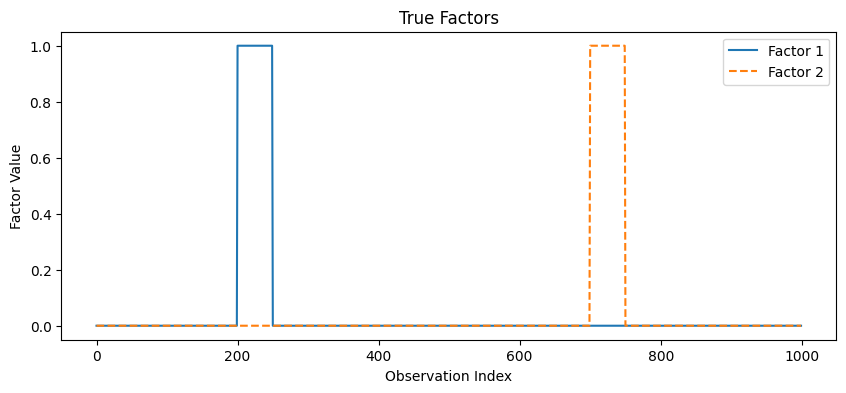

In [4]:
f1 = torch.zeros(P)
f1[200:250] = 1

f2 = torch.zeros(P)
f2[700:750] = 1

plt.figure(figsize=(10, 4))
plt.plot(f1, label='Factor 1')
plt.plot(f2, label='Factor 2', ls='--')
plt.legend()
plt.title('True Factors')
plt.xlabel('Observation Index')
plt.ylabel('Factor Value');

Generate random, noiseless observations for ATAC

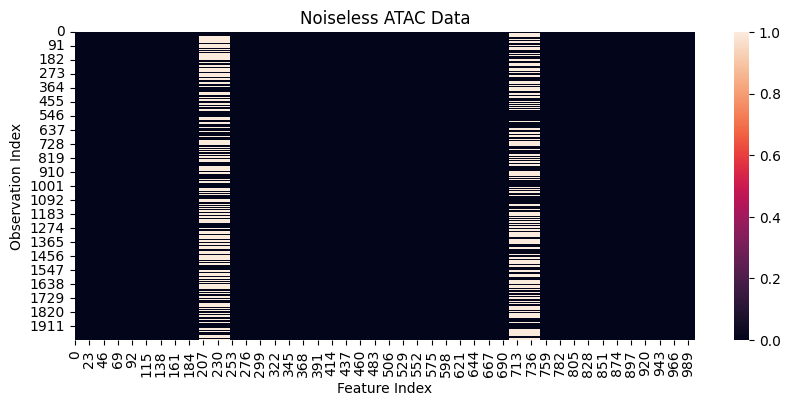

In [5]:
L1=   torch.randint(0, 2, (N,), dtype=torch.float32) 
L2=   torch.randint(0, 2, (N,), dtype=torch.float32) 
F_ATAC= torch.vstack([f1, f2 ] )
L_ATAC= torch.vstack([L1, L2 ] ).T
X_ATAC= L_ATAC @F_ATAC 

plt.figure(figsize=(10, 4))
sns.heatmap(X_ATAC)
plt.title('Noiseless ATAC Data')
plt.xlabel('Feature Index')
plt.ylabel('Observation Index');

### RNA Data

We assume that RNA data can be formed from a rank-3 decomposition, consisting of spikes at threee particular feature indices. Note we will construct our observations from four basis factors here (which will be useful for our model for relating ATAC and RNA), although the rank is still 3.

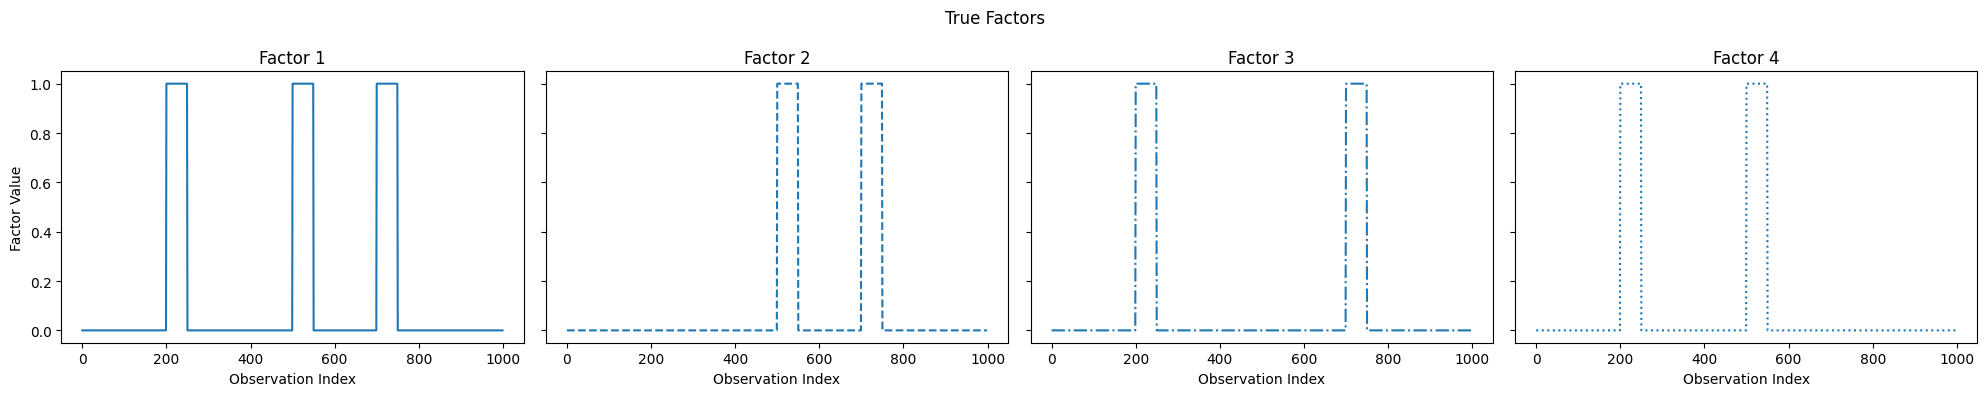

In [6]:
f1r= torch.zeros(P)
f1r[200:250]=1
f1r[500:550]=1
f1r[700:750]=1

f2r= torch.zeros(P)
f2r[500:550]=1
f2r[700:750]=1

f3r= torch.zeros(P)
f3r[200:250]=1
f3r[700:750]=1

f4r= torch.zeros(P)
f4r[200:250]=1
f4r[500:550]=1

fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
axs[0].plot(f1r, label='Factor 1')
axs[1].plot(f2r, label='Factor 2', ls='--')
axs[2].plot(f3r, label='Factor 3', ls='-.')
axs[3].plot(f4r, label='Factor 4', ls=':')
for i, ax in enumerate(axs):
    ax.set_title(f'Factor {i+1}')
    ax.set_xlabel('Observation Index')
axs[0].set_ylabel('Factor Value'); 
fig.suptitle('True Factors')

fig.tight_layout()

We assume that the noiseless RNA data is determined solely by the ATAC data for the same observation.

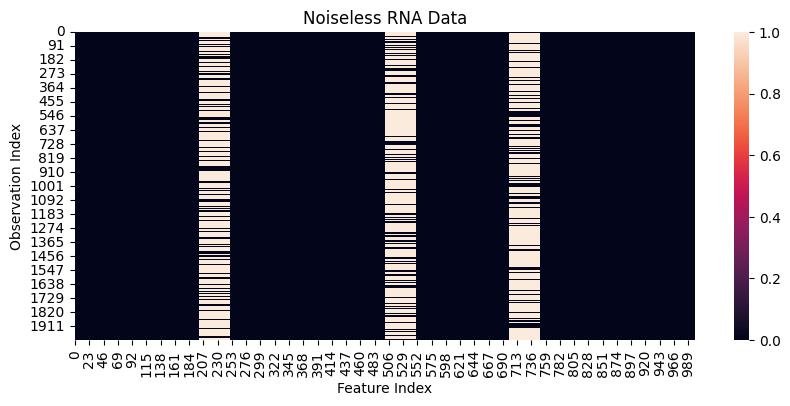

In [7]:
L_RNA = torch.zeros(N, 4)

L_RNA = torch.zeros(N, 4, dtype=torch.float32, device=L_ATAC.device)

mask01 = (L_ATAC[:,0] == 0) & (L_ATAC[:,1] == 1)  # -> col 0
mask10 = (L_ATAC[:,0] == 1) & (L_ATAC[:,1] == 0)  # -> col 1
mask11 = (L_ATAC[:,0] == 1) & (L_ATAC[:,1] == 1)  # -> col 2
mask00 = (L_ATAC[:,0] == 0) & (L_ATAC[:,1] == 0)  # -> col 3

L_RNA[mask01, 0] = 1
L_RNA[mask10, 1] = 1
L_RNA[mask11, 2] = 1
L_RNA[mask00, 3] = 1

f_RNA = torch.vstack([f1r,f2r,f3r,f4r])

X_RNA= L_RNA @ f_RNA
plt.figure(figsize=(10, 4))
plt.title('Noiseless RNA Data')
sns.heatmap(X_RNA)
plt.xlabel('Feature Index')
plt.ylabel('Observation Index');

### Noise data

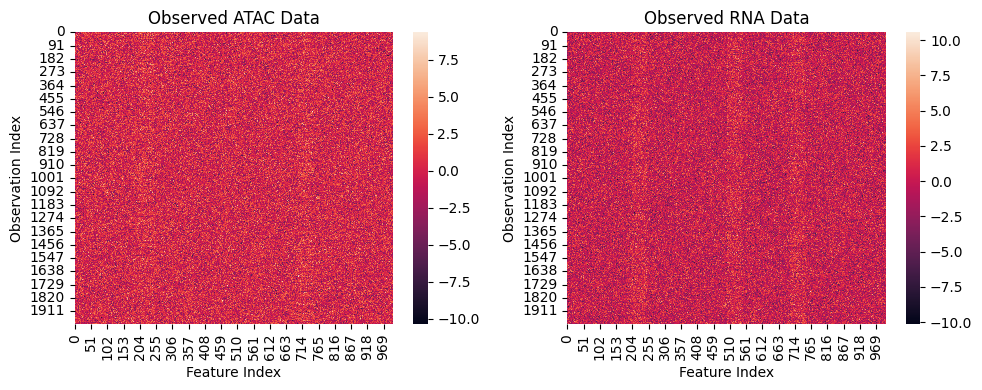

In [8]:
X_obs_RNA = X_RNA + 2*torch.randn(N, P)
X_obs_ATAC = X_ATAC + 2*torch.randn(N, P)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(X_obs_ATAC)
plt.title('Observed ATAC Data')
plt.xlabel('Feature Index')
plt.ylabel('Observation Index')
plt.subplot(1, 2, 2)
sns.heatmap(X_obs_RNA)
plt.title('Observed RNA Data')
plt.xlabel('Feature Index')
plt.ylabel('Observation Index')
plt.tight_layout();

## Perform EMBF separately for RNA and ATAC
 
In this section, we demonstrate the simplest scenario: we assume that the RNA and ATAC datasets are uncoupled, meaning there is no explicit sharing of information between them during modeling.
 
We fit the cEBMF model independently to each dataset. This allows us to see how the model performs when each data type is analyzed in isolation, without leveraging any potential relationships between them.
 
This serves as a baseline for comparison with the joint/covariate modeling approach shown later in the example.

In [9]:
nepoch = 20

print('Fitting RNA data...')
mycebmf0R = cEBMF(data=X_obs_RNA, K=10)
mycebmf0R.initialise_factors()
res_RNA = mycebmf0R.fit(nepoch)

print('Fitting ATAC data...')
mycebmf0A = cEBMF(data=X_obs_ATAC, K=10)
mycebmf0A.initialise_factors()
res_ATAC = mycebmf0A.fit(nepoch);

Fitting RNA data...
Fitting ATAC data...
Fitting ATAC data...


Here we check the loss as a function of iteration to see if our model has converged

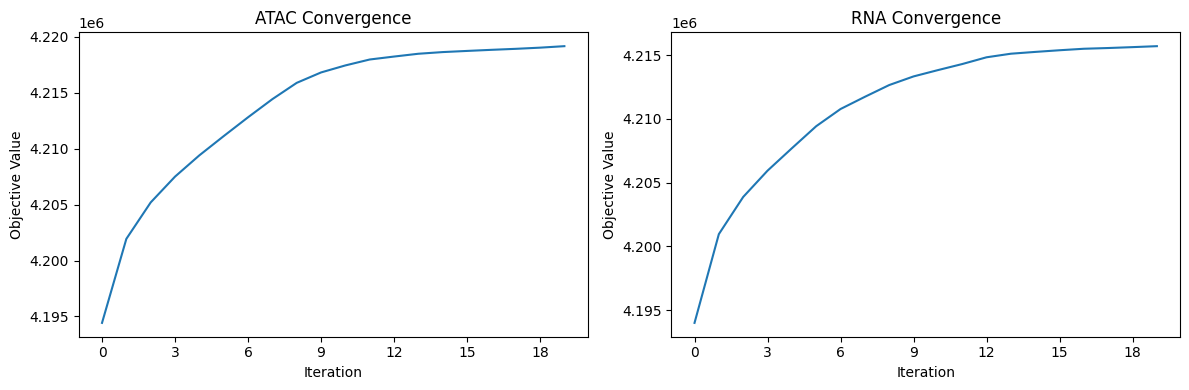

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(res_ATAC.history_obj)
axs[0].set_title('ATAC Convergence')
axs[1].plot(res_RNA.history_obj)
axs[1].set_title('RNA Convergence')
for ax in axs:
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Objective Value')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.tight_layout();

Visualize the posterior mean loadings for ATAC and RNA

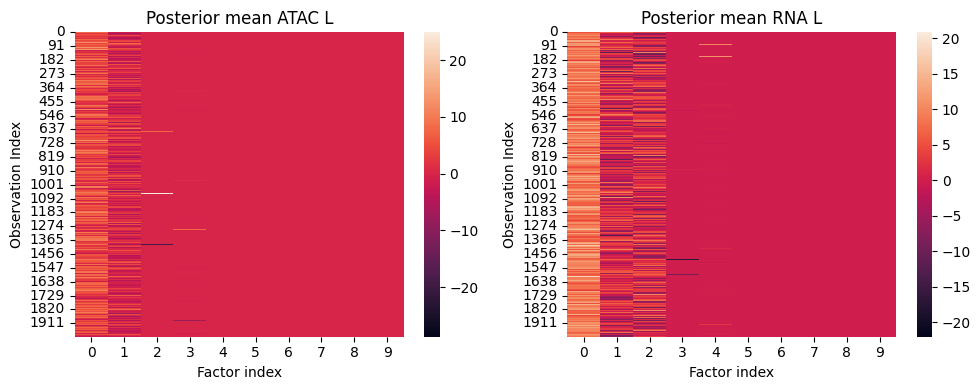

In [11]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(res_ATAC.L.cpu())
plt.title('Posterior mean ATAC L')
plt.xlabel('Factor index')
plt.ylabel('Observation Index')
plt.subplot(1, 2, 2)
sns.heatmap(res_RNA.L.cpu())
plt.title('Posterior mean RNA L')
plt.xlabel('Factor index')
plt.ylabel('Observation Index')
plt.tight_layout();


Visualize the posterior mean factors for ATAC and RNA

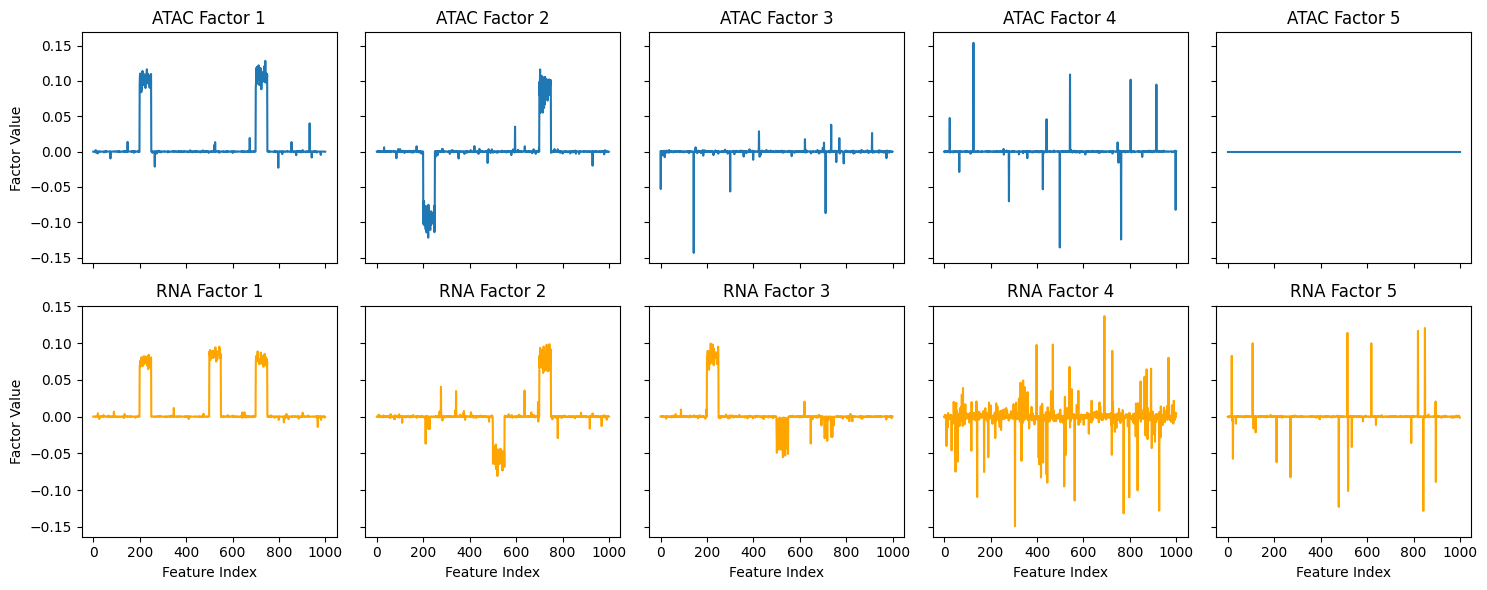

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey='row')

for i in range(axs.shape[1]):

    axs[0,i].plot(res_ATAC.F[:,i].cpu(), label=f'Factor {i+1}')
    axs[1,i].plot(res_RNA.F[:,i].cpu(), label=f'Factor {i+1}', color='orange')
    axs[0,i].set_title(f'ATAC Factor {i+1}')
    axs[1,i].set_title(f'RNA Factor {i+1}')

    axs[1,i].set_xlabel('Feature Index')

for ax in axs[:,0]:
    ax.set_ylabel('Factor Value')

fig.tight_layout();

## Covariate EMBF Model for RNA and ATAC

We now try to use the covariate information of RNA to inform our ATAC prior,
and the information of ATAC to inform our RNA prior.

Instead of starting from scratch, we use our inferred $L$ and $F$ from the EMBF
analysis above to determine the initial $L$ and $F$ for this analysis (overriding
the default SVD values for this).

At each step in the optimisation, we take the current posterior mean $L$ from 
ATAC as our covariate for $L$ of RNA. For the covariate of $F$, we use feature index.
Once we have a new estimate of $L$ for RNA, we then feed this into our ATAC inference
to be used as the covariate of $L$ for ATAC. We continue this for many interations
and hope for convergence.

In [13]:
# Feature index as the covariate for F
y_rna = torch.arange(1, X_obs_RNA.shape[1] + 1, dtype=torch.float32)
y_atac = torch.arange(1, X_obs_ATAC.shape[1] + 1, dtype=torch.float32)

In [14]:
prior = 'emdn'

mycebmfR = cEBMF(
    data=X_obs_RNA,
    prior_F=prior,
    X_f=y_rna,
    K=10,
    allow_backfitting=False
)
mycebmfR.initialise_factors()

mycebmfA = cEBMF(
    data=X_obs_ATAC,
    prior_F=prior,
    X_f=y_atac,
    K=10,
    allow_backfitting=False
)
mycebmfA.initialise_factors()

# Override initial values with previous fits
mycebmfR.L = mycebmf0R.L
mycebmfR.F = mycebmf0R.F
mycebmfA.L = mycebmf0A.L
mycebmfA.F = mycebmf0A.F

In [15]:
nupdate = 30

RNA_loss = []
ATAC_loss = []

# Compute initial losses
mycebmfR._cal_obj()
RNA_loss_init = mycebmfR.obj[-1]
mycebmfA._cal_obj()
ATAC_loss_init = mycebmfA.obj[-1]

print(f'Initial RNA loss: {RNA_loss_init:.2f}')
print(f'Initial ATAC loss: {ATAC_loss_init:.2f}')

for i in range(nupdate):
    print(f'Update {i+1}/{nupdate}', flush=True)

    mycebmfR.X_l= mycebmfA.L
    with suppress_stdout():
        mycebmfR.iter_once()
    RNA_loss.append(mycebmfR.obj[-1] - RNA_loss_init) 
    print(f'\tChange in RNA loss since start: {RNA_loss[-1]:.2f}', flush=True)

    mycebmfA.X_l= mycebmfR.L
    with suppress_stdout():
        mycebmfA.iter_once()
    ATAC_loss.append(mycebmfA.obj[-1] - ATAC_loss_init)
    print(f'\tChange in ATAC loss since start: {ATAC_loss[-1]:.2f}', flush=True)
    

Initial RNA loss: 4249382.50
Initial ATAC loss: 4250857.00
Update 1/30
	Change in RNA loss since start: -28035.00
	Change in RNA loss since start: -28035.00
	Change in ATAC loss since start: -31397.00
Update 2/30
	Change in ATAC loss since start: -31397.00
Update 2/30
	Change in RNA loss since start: -46141.00
	Change in RNA loss since start: -46141.00
	Change in ATAC loss since start: -45089.00
Update 3/30
	Change in ATAC loss since start: -45089.00
Update 3/30
	Change in RNA loss since start: -45862.00
	Change in RNA loss since start: -45862.00
	Change in ATAC loss since start: -45128.50
Update 4/30
	Change in ATAC loss since start: -45128.50
Update 4/30
	Change in RNA loss since start: -45947.00
	Change in RNA loss since start: -45947.00
	Change in ATAC loss since start: -46089.50
Update 5/30
	Change in ATAC loss since start: -46089.50
Update 5/30
	Change in RNA loss since start: -46693.50
	Change in RNA loss since start: -46693.50
	Change in ATAC loss since start: -49195.50
Update 

Again, we must check that our model has converged

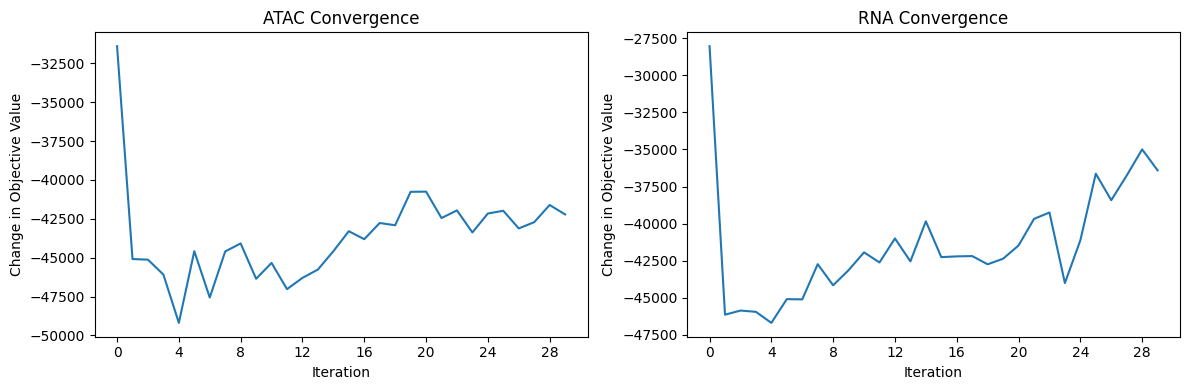

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(ATAC_loss)
axs[0].set_title('ATAC Convergence')
axs[1].plot(RNA_loss)
axs[1].set_title('RNA Convergence')
for ax in axs:
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Change in Objective Value')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.tight_layout();

Visualize the new posterior means for the loadings

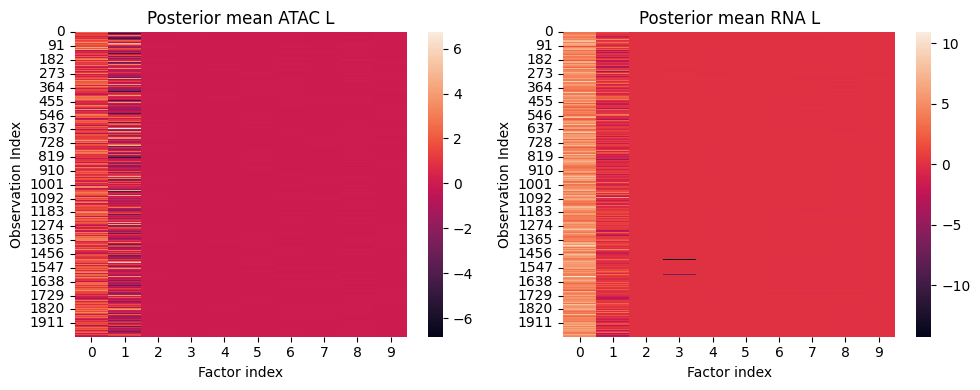

In [17]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(mycebmfA.L.cpu())
plt.title('Posterior mean ATAC L')
plt.xlabel('Factor index')
plt.ylabel('Observation Index')
plt.subplot(1, 2, 2)
sns.heatmap(mycebmfR.L.cpu())
plt.title('Posterior mean RNA L')
plt.xlabel('Factor index')
plt.ylabel('Observation Index')
plt.tight_layout();


And the new posterior means for the factors

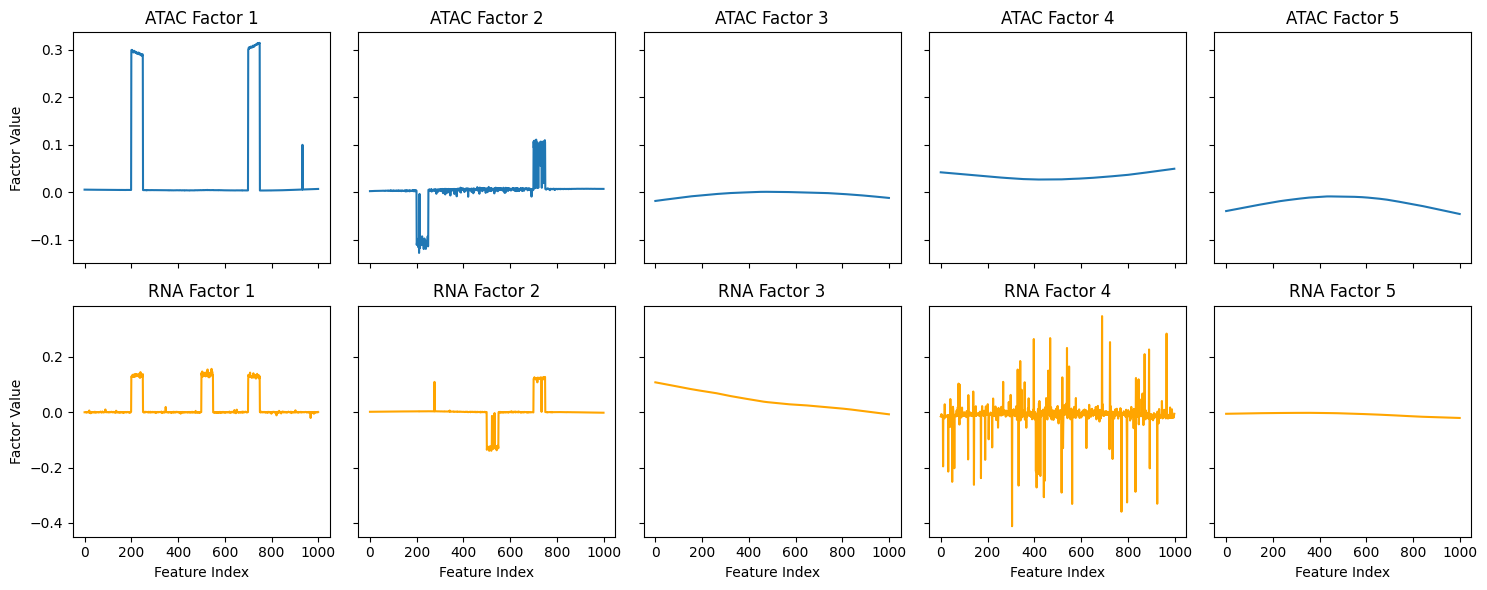

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey='row')

for i in range(axs.shape[1]):

    axs[0,i].plot(mycebmfA.F[:,i].cpu(), label=f'Factor {i+1}')
    axs[1,i].plot(mycebmfR.F[:,i].cpu(), label=f'Factor {i+1}', color='orange')
    axs[0,i].set_title(f'ATAC Factor {i+1}')
    axs[1,i].set_title(f'RNA Factor {i+1}')

    axs[1,i].set_xlabel('Feature Index')

for ax in axs[:,0]:
    ax.set_ylabel('Factor Value')

fig.tight_layout();